In [1]:
import torch
torch.__version__

'2.5.1'

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device # select gpu from edit -> notebook settings ->gpu

'cuda'

In [4]:
# Setup directory paths to train and test images
train_dir = '../../Yolo/Toplu/train'
test_dir = '../../Yolo/Toplu/val'

In [5]:
#  Create Datasets and DataLoaders

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
  )

  return train_dataloader, test_dataloader, class_names

In [6]:
# # Create image size
# IMG_SIZE = 224

# # Create transform pipeline manually
# manual_transforms = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor(),
# ])
# print(f"Manually created transforms: {manual_transforms}")

In [7]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    

class_count=3

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=class_count).to(device)
# pretrained_vit # uncomment for model output 

In [8]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [9]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [10]:
# import random
# import numpy as np

# for t in (manual_transforms.transforms):
#     print(f"Transform: {t} - {type(t)}")
#     # Visualize the effect of transforms on sample images

#     # Get a few sample images from the training dataset
#     train_data_original = datasets.ImageFolder(train_dir, transform=None)  # Without transforms
#     train_data_transformed = datasets.ImageFolder(train_dir, transform=manual_transforms)  # With transforms

#     # Get 3 random samples (or fewer if dataset is smaller)
#     num_samples = min(3, len(train_data_original))
#     sample_indices = random.sample(range(len(train_data_original)), num_samples)

#     # Create a figure to display original and transformed images
#     fig, axs = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))
#     fig.suptitle("Original vs Transformed Images")

#     for i, idx in enumerate(sample_indices):
#         img_orig, label = train_data_original[idx]
#         img_transformed, _ = train_data_transformed[idx]
        
#         # Handle case where we only have one sample
#         if num_samples == 1:
#             ax_orig, ax_trans = axs
#         else:
#             ax_orig, ax_trans = axs[i]
        
#         # Plot original image
#         ax_orig.imshow(np.array(img_orig))
#         ax_orig.set_title(f"Original: {class_names[label]}")
#         ax_orig.axis('off')
        
#         # Plot transformed image
#         ax_trans.imshow(img_transformed.permute(1, 2, 0))
#         ax_trans.set_title(f"Transformed: {class_names[label]}")
#         ax_trans.axis('off')

#     plt.tight_layout()
#     plt.subplots_adjust(top=0.95)
#     plt.show()

In [11]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names



(<torch.utils.data.dataloader.DataLoader at 0x27910719610>,
 ['HiperakutAkut', 'NormalKronik', 'Subakut'])

In [12]:
for images, labels in test_dataloader:
    print(f"Image batch shape: {images.shape}")
    print(f"Labels batch shape: {labels.shape}")
    break

Image batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224]) tensor(0)


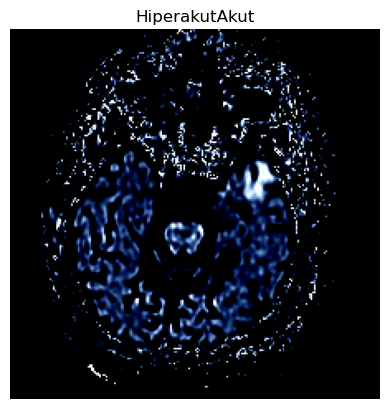

In [13]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [14]:
import vit_transformer_module
from vit_transformer_module import PatchEmbedding
from vit_transformer_module import MultiheadSelfAttentionBlock
from vit_transformer_module import MLPBlock
from vit_transformer_module import TransformerEncoderBlock
from vit_transformer_module import ViT

In [15]:
# totalParameter=0

# for p in vit.parameters():
#     print(f"Parameter: {p.flatten().shape} - {p.dtype} - {p.device}")
#     totalParameter += p.flatten().shape[0]
# print(f"Total number of parameters in ViT model: {totalParameter:,}")



In [16]:
# import time
# startTime = time.time()
# for images, labels in train_dataloader:
#     print(f"Image batch shape: {images.shape}")
#     print(f"Labels batch shape: {labels.shape}")

# print(f"Time taken to load a batch of images: {time.time() - startTime:.2f} seconds")

In [17]:

# import engine

# # Create optimizer and loss function
# optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
#                              lr=1e-3)
# loss_fn = torch.nn.CrossEntropyLoss()

# # Train the classifier head of the pretrained ViT feature extractor model
# set_seeds()
# pretrained_vit_results = engine.train(model=pretrained_vit,
#                                       train_dataloader=train_dataloader,
#                                       test_dataloader=test_dataloader,
#                                       optimizer=optimizer,
#                                       loss_fn=loss_fn,
#                                       epochs=50,
#                                       device=device)



# torch.save(vit.state_dict(), 'vit_trained_model.pth')

In [18]:
# NON pretrained ViT model training

# Train our MOdel
# Create an instance of ViT with the number of classes we're working with (daisy, dandelion)
vit = ViT(num_classes=len(class_names))



# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()


import engine
# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=70,
                       device=device,
                       pretrained=False,)

# Save the trained model's state_dict
# torch.save(vit.state_dict(), 'vit_trained_model.pth')


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2049 | train_acc: 0.4877 | test_loss: 0.9744 | test_acc: 0.5067
Epoch: 2 | train_loss: 0.9051 | train_acc: 0.5015 | test_loss: 0.9557 | test_acc: 0.5067
Epoch: 3 | train_loss: 0.9032 | train_acc: 0.4951 | test_loss: 0.9220 | test_acc: 0.5067
Epoch: 4 | train_loss: 0.8969 | train_acc: 0.5044 | test_loss: 0.9224 | test_acc: 0.5067
Epoch: 5 | train_loss: 0.9012 | train_acc: 0.5116 | test_loss: 0.9252 | test_acc: 0.5067
Model saved to saved_models_nonpretrained_20250603-120147/model_epoch_5_0.5067.pth testing accuracy: 0.5067
Epoch: 6 | train_loss: 0.9105 | train_acc: 0.5164 | test_loss: 0.9304 | test_acc: 0.5067
Epoch: 7 | train_loss: 0.9049 | train_acc: 0.5191 | test_loss: 0.9197 | test_acc: 0.5067
Epoch: 8 | train_loss: 0.8962 | train_acc: 0.5164 | test_loss: 0.9211 | test_acc: 0.5067
Epoch: 9 | train_loss: 0.8962 | train_acc: 0.5164 | test_loss: 0.9281 | test_acc: 0.5067
Epoch: 10 | train_loss: 0.8964 | train_acc: 0.5191 | test_loss: 0.9262 | test_acc: 0.5067
M

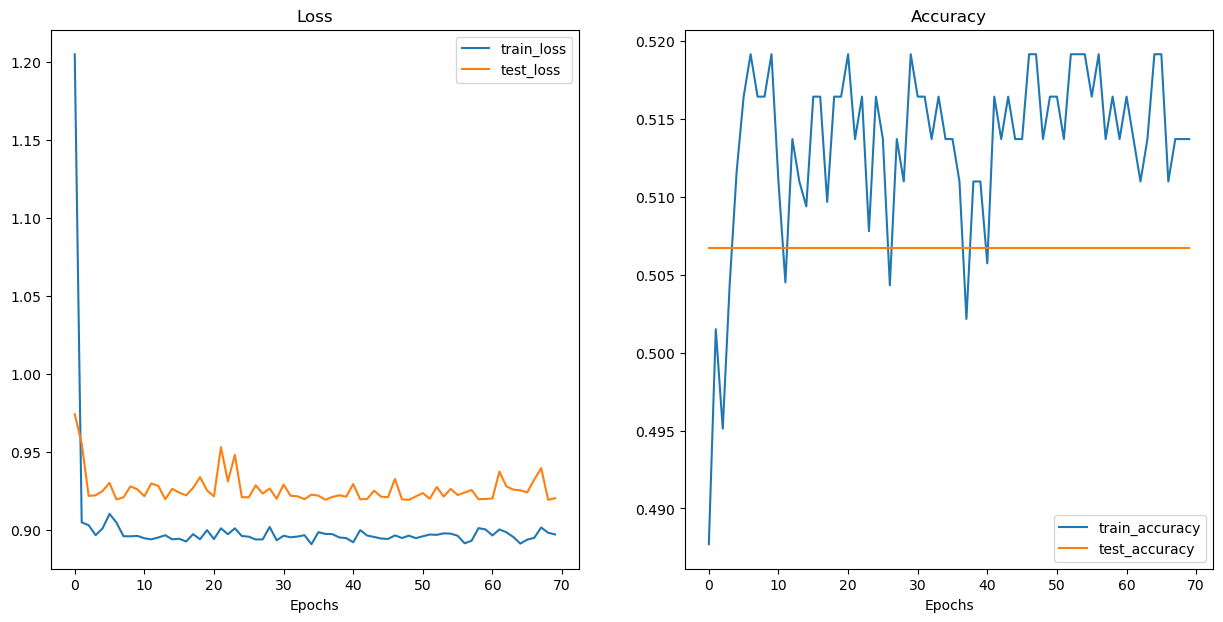

In [20]:
# # To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves


# Plot our ViT model's loss curves
plot_loss_curves(results)

In [21]:
import pickle

# Save the results dictionary to a pickle file
with open('saved_models_nonpretrained_20250603-120147/pretrained_vit_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
# # Inference using trained model
# import requests

# # Import function to make predictions on images and plot them
# from predictions import pred_and_plot_image

# # Setup custom image path
# custom_image_path = "../../Yolo/Toplu/train/HiperakutAkut/Vaka_300663_50467107.3.21_HiperakutAkut.png"

# # Predict on custom image
# pred_and_plot_image(model=vit,
#                     image_path=custom_image_path,
#                     class_names=class_names)